# Transformer-Architecture for the prediction of energy consumption data over 48 hours
### 1 - Transformer-Architecture with Energy consumption data and weather data
### 2 - Transformer-Architecture with Energy consumption data and 2 variables 'Lastgang_Moving_Average' and 'Lastgang_First_Difference'

In [18]:
#Install all required packages with 'conda install NAME' or with pip install NAME'
# pandas
# numpy
# matplotlib
# scikit-learn
# torch
# gputil
# psutil
# torchsummary

In [19]:
#Import all required libraries
import sys  # Provides access to some variables used or maintained by the interpreter
import pandas as pd # Library for data manipulation and analysis, ideal for working with structured data like tables
import numpy as np # For scientific computing, supports large, multi-dimensional arrays and matrices
import matplotlib.pyplot as plt # For creating static, interactive, and animated visualizations
import matplotlib.dates as mdates # Provides classes for manipulating dates in plots
from pathlib import Path  # Used for filesystem path manipulation in an object-oriented way
import torch # Scientific computing library for ML and neural networks
import torch.nn as nn # Module in PyTorch providing various layers and parameters for neural networks, facilitates building and training
from sklearn.metrics import mean_squared_error, mean_absolute_error # For calculating key regression metrics
from sklearn.preprocessing import MinMaxScaler # For scaling and normalizing features, often useful in data preprocessing
import os # Provides a way of using operating system dependent functionality
import GPUtil # For monitoring GPU utilization
from datetime import datetime # For handling dates and times
import psutil # For accessing system details and process utilities
from torchsummary import summary  # Import summary from torchsummary to display a summary of model layers and parameters

In [20]:
#To display the current environment
print(sys.executable)

/home/sarah/anaconda3/envs/BT2024PyTorch/bin/python


In [21]:
# Step 1 - Reading Data

## dfClimaAll: Data from 2021-2023
## dfEnergyAll: All data from the transformer station from 2021-2023

# Load data for 2021
dfClima21 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2021TimeWeather.xlsx')

# Load data for 2022
dfClima22 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2022TimeWeather.xlsx')

# Load data for 2023
dfClima23 = pd.read_excel('/home/sarah/Documents/BT2024/Weather_Data/2023TimeWeather.xlsx')

# Merge the DataFrames
dfClimaAll = pd.concat([dfClima21, dfClima22, dfClima23])

# Check the resulting DataFrame
print("First and last rows from dfClimaAll:")
print(dfClimaAll.head())
print(dfClimaAll.tail())

# Check for missing values in each column
## .isnull(): Returns DF where values with NaN are replaced by True & values without NaN are replaced by False
## sum(): Sums up the number of True values
print("Number of missing values per column:")
print(dfClimaAll.isnull().sum())

# Convert 'Timestamp' into a Datetime object and set it as index, if not already set
if 'TimestampWeather' in dfClimaAll.columns:
    ## pd.to_datetime: Converts values into Datetime objects —> Pandas can then treat these as timestamps
    dfClimaAll['TimestampWeather'] = pd.to_datetime(dfClimaAll['TimestampWeather'])
    ## set_index: Sets index for the Timestamp column to facilitate access to data based on time points
    dfClimaAll = dfClimaAll.set_index('TimestampWeather')

# Number of rows in dfClimaAll
print("Number of rows in dfClimaAll:", dfClimaAll.shape[0])

First and last rows from dfClimaAll:
   dy  Globalstrahlung_15Min  Sonnenhöhe  ExtraterrestrischeStrahlung  \
0   1                      0       -65.0                            0   
1   1                      0       -65.0                            0   
2   1                      0       -65.4                            0   
3   1                      0       -65.5                            0   
4   1                      0       -65.2                            0   

   StundenwertStrahlung  Diffusstrahlung  StrahlungGeneigteFläche  \
0                     0                0                        0   
1                     0                0                        0   
2                     0                0                        0   
3                     0                0                        0   
4                     0                0                        0   

   DiffusstrahlungGeneigteFläche  Direktnormalstrahlung  Lufttemperatur  \
0                              0  

In [22]:
# Step 1 - Reading Data

## dfClimaAll: Data from 2021-2023
## dfEnergyAll: All data from the transformer station from 2021-2023

# Path to the directory containing the Excel files
directory_path = Path('/home/sarah/Documents/BT2024/All')

# Create a list of all Excel files in the directory
file_paths = list(directory_path.glob('*.xlsx'))

# List to store the individual DataFrames
dfs = []

# Loop over all file paths
for file_path in file_paths:
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Convert the 'Timestamp' column to a datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Convert the 'Lastgang' column to a numeric type, treat errors as NaN
    df['Lastgang'] = pd.to_numeric(df['Lastgang'], errors='coerce')
    
    # Sort the DataFrame by 'Timestamp'
    df = df.sort_values(by='Timestamp')
    
    # Perform linear interpolation for 'Lastgang' on the individual DataFrame
    df['Lastgang'] = df['Lastgang'].interpolate(method='linear')
    
    # Add the DataFrame to the list
    dfs.append(df)

# Merge all DataFrames in the list
dfEnergyAll = pd.concat(dfs).set_index('Timestamp')

# Sum the 'Lastgang' values for identical timestamps
dfEnergyAll = dfEnergyAll.groupby('Timestamp').sum()

# Check the resulting DataFrame
print("First and last rows from dfEnergyAll:")
print(dfEnergyAll.head())
print(dfEnergyAll.tail())

# Display the number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])

First and last rows from dfEnergyAll:
                     Lastgang
Timestamp                    
2021-01-01 00:00:00    472.88
2021-01-01 00:15:00    498.83
2021-01-01 00:30:00    480.48
2021-01-01 00:45:00    446.74
2021-01-01 01:00:00    459.55
                     Lastgang
Timestamp                    
2023-12-31 22:45:00    833.17
2023-12-31 23:00:00    767.89
2023-12-31 23:15:00    770.04
2023-12-31 23:30:00    730.45
2023-12-31 23:45:00    744.21
Number of rows in dfEnergyAll: 105108


In [23]:
# Step 2 - Preparing the Data

# Create a complete timestamp index for the years 2021 - 2023 in 15-minute intervals
all_timestamps = pd.date_range(start='2021-01-01 00:00:00', end='2023-12-31 23:45:00', freq='15T')

# Convert this into a DataFrame
df_all_timestamps = pd.DataFrame(all_timestamps, columns=['Timestamp'])
df_all_timestamps = df_all_timestamps.set_index('Timestamp')

# Compare the complete timestamp index with dfEnergyAll
missing_timestamps = df_all_timestamps.index.difference(dfEnergyAll.index)

print("Missing timestamps in dfEnergyAll:")
print(missing_timestamps)


# Missing timestamps
missing_timestamps = pd.DatetimeIndex(['2021-03-28 02:00:00', '2021-03-28 02:15:00',
                                       '2021-03-28 02:30:00', '2021-03-28 02:45:00',
                                       '2022-03-27 02:00:00', '2022-03-27 02:15:00',
                                       '2022-03-27 02:30:00', '2022-03-27 02:45:00',
                                       '2023-03-26 02:00:00', '2023-03-26 02:15:00',
                                       '2023-03-26 02:30:00', '2023-03-26 02:45:00'])

# Create a DataFrame with the missing timestamps
df_missing = pd.DataFrame(index=missing_timestamps)

# Merge this DataFrame with the original DataFrame
dfEnergyAll = dfEnergyAll.combine_first(df_missing)

# Fill the missing values. Use 'ffill' for forward fill.
dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')

print("Check after adding the missing timestamps:")
print(dfEnergyAll.loc[missing_timestamps])

# Number of rows in dfClimaAll
# Ensure dfClimaAll is already defined before executing this line.
print("Number of rows in dfClimaAll:", dfClimaAll.shape[0])

# Number of rows in dfEnergyAll
print("Number of rows in dfEnergyAll:", dfEnergyAll.shape[0])

Missing timestamps in dfEnergyAll:
DatetimeIndex(['2021-03-28 02:00:00', '2021-03-28 02:15:00',
               '2021-03-28 02:30:00', '2021-03-28 02:45:00',
               '2022-03-27 02:00:00', '2022-03-27 02:15:00',
               '2022-03-27 02:30:00', '2022-03-27 02:45:00',
               '2023-03-26 02:00:00', '2023-03-26 02:15:00',
               '2023-03-26 02:30:00', '2023-03-26 02:45:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)
Check after adding the missing timestamps:
                     Lastgang
2021-03-28 02:00:00    372.28
2021-03-28 02:15:00    372.28
2021-03-28 02:30:00    372.28
2021-03-28 02:45:00    372.28
2022-03-27 02:00:00    554.20
2022-03-27 02:15:00    554.20
2022-03-27 02:30:00    554.20
2022-03-27 02:45:00    554.20
2023-03-26 02:00:00    520.34
2023-03-26 02:15:00    520.34
2023-03-26 02:30:00    520.34
2023-03-26 02:45:00    520.34
Number of rows in dfClima21: 105120
Number of rows in dfEnergyAll: 105120


/tmp/ipykernel_1514653/1871761932.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfEnergyAll = dfEnergyAll.sort_index().fillna(method='ffill')


## 1 - Transformer-Architecture with Energy consumption data and weather data

In [24]:
# Step 2 - Preparing the Data

# To check if the indexes in both DataFrames are set equally
dfClimaAll.index.equals(dfEnergyAll.index)

# Adding the columns from dfClima21 to dfEnergyAll
dfEnergyAll = dfEnergyAll.join(dfClimaAll[['StundenwertStrahlung', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'TheorPVProd', 'Direktnormalstrahlung', 'Schönwetterstrahlung', 'Lufttemperatur']])

# Checking for missing values in each column
print("Number of missing values per column:")
print(dfEnergyAll.isnull().sum())

# Printing the first and last rows from the dataframe
print("First and last rows from dfEnergyAll-Edited:")
print(dfEnergyAll.head())
print(dfEnergyAll.tail())

Number of missing values per column:
Lastgang                   0
StundenwertStrahlung       0
Globalstrahlung_15Min      0
StrahlungGeneigteFläche    0
TheorPVProd                0
Direktnormalstrahlung      0
Schönwetterstrahlung       0
Lufttemperatur             0
dtype: int64
First and last rows from dfEnergyAll-Edited:
                     Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
2021-01-01 00:00:00    472.88                     0                      0   
2021-01-01 00:15:00    498.83                     0                      0   
2021-01-01 00:30:00    480.48                     0                      0   
2021-01-01 00:45:00    446.74                     0                      0   
2021-01-01 01:00:00    459.55                     0                      0   

                     StrahlungGeneigteFläche  TheorPVProd  \
2021-01-01 00:00:00                        0            0   
2021-01-01 00:15:00                        0            0   
2021-01-01 00:30:00  

In [25]:
# Step 2 - Preparing the Data

# Calculating the moving average for 'Lastgang'
window_size = 96  # This corresponds to 24 hours at 15-minute intervals
dfEnergyAll['Lastgang_Moving_Average'] = dfEnergyAll['Lastgang'].rolling(window=window_size).mean()

# Calculating the first differences for 'Lastgang'
dfEnergyAll['Lastgang_First_Difference'] = dfEnergyAll['Lastgang'].diff()

# Since the first `window_size - 1` values of the moving average will be NaN and the first value of the first difference will be NaN, fill these values.
dfEnergyAll = dfEnergyAll.fillna(method='bfill')

# To check the first few rows to ensure the new features look as expected.
print(dfEnergyAll.head())

                     Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
2021-01-01 00:00:00    472.88                     0                      0   
2021-01-01 00:15:00    498.83                     0                      0   
2021-01-01 00:30:00    480.48                     0                      0   
2021-01-01 00:45:00    446.74                     0                      0   
2021-01-01 01:00:00    459.55                     0                      0   

                     StrahlungGeneigteFläche  TheorPVProd  \
2021-01-01 00:00:00                        0            0   
2021-01-01 00:15:00                        0            0   
2021-01-01 00:30:00                        0            0   
2021-01-01 00:45:00                        0            0   
2021-01-01 01:00:00                        0            0   

                     Direktnormalstrahlung  Schönwetterstrahlung  \
2021-01-01 00:00:00                      0                     0   
2021-01-01 00:15:00         

/tmp/ipykernel_1514653/1800522370.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfEnergyAll = dfEnergyAll.fillna(method='bfill')


In [26]:
# Step 3 - Data Scaling

# Initialize the scalers
lastgang_scaler = MinMaxScaler(feature_range=(0, 1))
features_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the corresponding columns
dfEnergyAll['Lastgang'] = lastgang_scaler.fit_transform(dfEnergyAll['Lastgang'].values.reshape(-1, 1))
dfEnergyAll[['StundenwertStrahlung', 'Lufttemperatur', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']] = features_scaler.fit_transform(dfEnergyAll[['StundenwertStrahlung', 'Lufttemperatur', 'Globalstrahlung_15Min', 'StrahlungGeneigteFläche', 'Lastgang_Moving_Average', 'Lastgang_First_Difference']])

In [27]:
# Step 3 - Check the scaled values

print(dfEnergyAll.describe())

print("Skalierparameter für Lastgang:", lastgang_scaler.scale_, lastgang_scaler.min_)

            Lastgang  StundenwertStrahlung  Globalstrahlung_15Min  \
count  105120.000000         105120.000000          105120.000000   
mean        0.425947              0.561652               0.125328   
std         0.149590              0.111328               0.197261   
min         0.000000              0.000000               0.000000   
25%         0.312299              0.490186               0.000000   
50%         0.397657              0.492149               0.000861   
75%         0.527101              0.593719               0.182444   
max         1.000000              1.000000               1.000000   

       StrahlungGeneigteFläche    TheorPVProd  Direktnormalstrahlung  \
count            105120.000000  105120.000000          105120.000000   
mean                  0.125328     116.568056             144.916924   
std                   0.197261     177.407501             266.941484   
min                   0.000000       0.000000               0.000000   
25%               

In [28]:
# Step 3 - Show GPU Utilization and Memory Usage before Model Training

def print_gpu_utilization():
    # Retrieve and print GPU utilization and memory stats
    GPUs = GPUtil.getGPUs()
    for GPU in GPUs:
        print(f"GPU: {GPU.name}, GPU RAM Free: {GPU.memoryFree}MB, Used: {GPU.memoryUsed}MB, Utilization: {GPU.load*100}%")

print("GPU before model training:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print_gpu_utilization()

# Function to print CPU utilization
def print_cpu_utilization():
    # Retrieve and print the percentage of CPU utilization
    print(f"CPU Utilization: {psutil.cpu_percent(interval=1)}%")

print("CPU before model training:")
print_cpu_utilization()

def print_memory_usage():
    # Retrieve and print memory statistics
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage: {memory.percent}%")

print("RAM before model training:")
print_memory_usage()


GPU before model training: 2024-05-03 17:23:54
GPU: NVIDIA A100 80GB PCIe, GPU RAM Free: 15712.0MB, Used: 65326.0MB, Utilization: 4.0%
GPU: NVIDIA A100 80GB PCIe, GPU RAM Free: 236.0MB, Used: 80803.0MB, Utilization: 100.0%
CPU before model training:
CPU Utilization: 82.1%
RAM before model training:
Total memory: 146.88 GB
Available memory: 110.48 GB
Used memory: 34.61 GB
Memory usage: 24.8%


In [29]:
# Step 4 - Creating the sequences, positional encoding and the LSTM model

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].to_numpy()  # Extract sequence from data
        y = data.iloc[i + seq_length, 0]  # Extract target value for the sequence
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)  # Convert lists to numpy arrays

seq_length = 192  # Length of each sequence
X, y = create_sequences(dfEnergyAll, seq_length)  # Create sequences from data

# Use the last 192 sequences for testing to maintain a comparable distribution as the TBATS model
X_train, X_test = X[:-192], X[-192:]  # Split data into training and testing sets
y_train, y_test = y[:-192], y[-192:]  # Split targets into training and testing sets


# Function for positional encoding
def positional_encoding(seq_len, d_model):
    encoding = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_model) for j in range(d_model)]
        if pos != 0 else np.zeros(d_model)
        for pos in range(seq_len)
    ])
    encoding[1:, 0::2] = np.sin(encoding[1:, 0::2])  # Apply sin to even indices
    encoding[1:, 1::2] = np.cos(encoding[1:, 1::2])  # Apply cos to odd indices
    return encoding

# Apply positional encodings
d_model = X_train.shape[2]  # Number of features in the data
pos_enc = positional_encoding(seq_length, d_model)  # Generate positional encoding

# Add positional encodings to the sequences
X_train_enc = np.array([x + pos_enc for x in X_train])  # Add encoding to training data
X_test_enc = np.array([x + pos_enc for x in X_test])  # Add encoding to testing data

In [30]:
# Step 4 - Creating the sequences and the LSTM model

# Print the shapes of the training and testing datasets
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")

# Print the shapes of the training and testing datasets with positional encodings applied
print(f"X_train_enc Shape: {X_train_enc.shape}")
print(f"X_test_enc Shape: {X_test_enc.shape}")

X_train Shape: (104736, 192, 10)
X_test Shape: (192, 192, 10)
X_train_enc Shape: (104736, 192, 10)
X_test_enc Shape: (192, 192, 10)


In [31]:
# Step 4 - Creating the sequences and the LSTM model

# Check Hardware Availability for the PyTorch code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# Step 4 - Creating the sequences and the LSTM model

X_train_tensors = torch.Tensor(X_train_enc).to(device)  # Convert training data to tensors and move to the designated device (GPU or CPU)
y_train_tensors = torch.Tensor(y_train).view(-1, 1).to(device)  # Convert training labels to tensors, reshape them and move to the device
X_test_tensors = torch.Tensor(X_test_enc).to(device)  # Convert testing data to tensors and move to the designated device
y_test_tensors = torch.Tensor(y_test).view(-1, 1).to(device)  # Convert testing labels to tensors, reshape them and move to the device

In [33]:
# Step 4 - Creating the sequences and the LSTM model

#Create Transformer Model
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers, nhead):
        super(TransformerModel, self).__init__()
        self.input_size = input_size  # Number of input features
        self.hidden_layer_size = hidden_layer_size  # Size of the hidden layer
        self.output_size = output_size  # Size of the output layer

        # Embedding layer that maps input features to the hidden layer size
        self.embedding = nn.Linear(input_size, hidden_layer_size)

        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_layer_size, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Linear layer for output
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, src):
        # Embedding
        src = self.embedding(src)  # Apply embedding layer to source data

        # Transformer Encoder
        src = src.permute(1, 0, 2)  # Permute the dimensions of src for the Transformer (expects [seq_len, batch, features])
        output = self.transformer_encoder(src)  # Pass the embedded src through the transformer encoder

        # Only take the output from the last time step for making predictions
        output = output[-1]

        # Linear layer
        output = self.linear(output)  # Apply linear layer to the output of the transformer
        return output

# Parameters
input_size = 10  # Number of features
hidden_layer_size = 100  # Size of the hidden layer
output_size = 1  # Output size
num_layers = 2  # Number of layers in the transformer
nhead = 2  # Number of attention heads

# Instantiate the model
model = TransformerModel(input_size, hidden_layer_size, output_size, num_layers, nhead).to(device)  # Create the model and move it to the designated device

/home/sarah/anaconda3/envs/BT2024PyTorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


from torchsummary import summary

# Angabe der Eingabedimension für torchsummary
seq_length = 192  # Sequenzlänge, wie im Modell verwendet
summary(model, input_size=(seq_length, input_size))

In [34]:
# Step 5 - Model Training

# Define the number of epochs and batch size
loss_function = nn.MSELoss()  # Loss function for measuring the mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer with a learning rate of 0.001
epochs = 70  # Total number of epochs to train the model
batch_size = 12  # Number of samples per batch

# For storing the loss values
train_losses = []  # List to store training loss values for each epoch
test_losses = []  # List to store validation loss values for each epoch

# Initialize variables for Early Stopping
best_test_loss = float('inf')  # Best validation loss seen so far, initialized to infinity
best_model_path = 'best_model.pth'  # Path to save the best performing model
early_stopping_patience = 5  # Number of epochs to continue without improvement before stopping
epochs_without_improvement = 0  # Counter to track epochs without improvement

for epoch in range(epochs):  # Loop over each epoch
    model.train()  # Set the model to training mode
    train_loss = 0.0  # Reset training loss for this epoch
    for i in range(0, len(X_train_tensors), batch_size):  # Iterate over the training data in batches
        X_batch = X_train_tensors[i:i + batch_size]  # Get the current batch of input data
        y_batch = y_train_tensors[i:i + batch_size]  # Get the current batch of target data

        # Dynamic adjustment of the batch size for the last batch of the epoch
        actual_batch_size = X_batch.size(0)

        optimizer.zero_grad()  # Reset the gradients to zero

        # No need to manage hidden states for the Transformer model
        y_pred = model(X_batch)  # Forward pass through the model

        loss = loss_function(y_pred, y_batch)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights
        
        train_loss += loss.item() * actual_batch_size  # Accumulate the loss

    # Calculate the average training loss for this epoch
    train_loss /= len(X_train_tensors)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # No gradient calculations
        for i in range(0, len(X_test_tensors), batch_size):
            X_batch = X_test_tensors[i:i + batch_size]
            y_batch = y_test_tensors[i:i + batch_size]

            y_pred = model(X_batch)  # Forward pass through the model for validation
            loss = loss_function(y_pred, y_batch)  # Calculate loss
            test_loss += loss.item() * actual_batch_size  # Accumulate the loss
        
    # Calculate the average validation loss for this epoch
    test_loss /= len(X_test_tensors)
    test_losses.append(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss  # Update the best test loss
        torch.save(model.state_dict(), best_model_path)  # Save the best model
        epochs_without_improvement = 0  # Reset the improvement counter
        print(f'New best model saved at epoch {epoch+1} with test loss {test_loss}.')
    else:
        epochs_without_improvement += 1  # Increment the no-improvement counter

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early Stopping after {epoch+1} epochs!')  # Stop training if no improvement
        break

/home/sarah/anaconda3/envs/BT2024PyTorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


New best model saved at epoch 1 with test loss 0.03984663731534965.
Epoch 1, Train Loss: 0.013731314026245361, Test Loss: 0.03984663731534965
New best model saved at epoch 2 with test loss 0.016820339420519304.
Epoch 2, Train Loss: 0.005286569327589577, Test Loss: 0.016820339420519304
Epoch 3, Train Loss: 0.006792317569947825, Test Loss: 0.017148404789622873
Epoch 4, Train Loss: 0.004567338423792936, Test Loss: 0.02858270751312375
Epoch 5, Train Loss: 0.004809053334021856, Test Loss: 0.017867928676423617
Epoch 6, Train Loss: 0.004574279051601939, Test Loss: 0.04403836881829193
Epoch 7, Train Loss: 0.0048564385962972505, Test Loss: 0.024106490673148073
Early Stopping after 7 epochs!


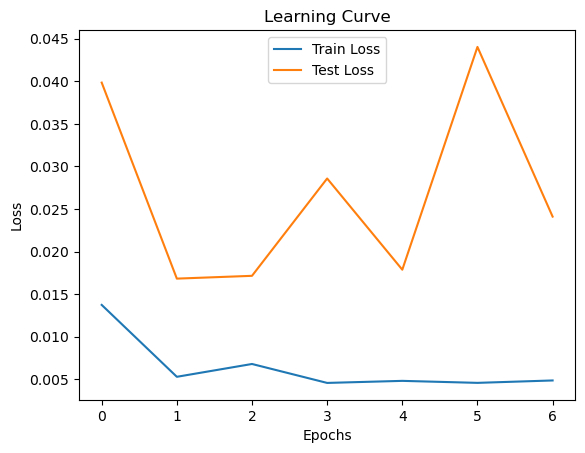

In [35]:
# Step 5 - Model Training

#Printing the learning curve
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

Learning Curve Chart: Die Lernkurve zeigt den Verlust von Trainings- und Testdaten über die Anzahl der Epochen. Der kontinuierliche Abwärtstrend beider Kurven deutet darauf hin, dass das Modell im Laufe der Zeit besser wird und keine Anzeichen von Überanpassung zeigt, da der Testverlust (orange Linie) dem Trainingsverlust (blaue Linie) folgt. Das Konvergieren beider Kurven ist ein gutes Zeichen dafür, dass das Modell generalisiert und nicht nur die Trainingsdaten auswendig lernt.

Mean Squared Error (MSE): 36304.058488096474
Mean Absolute Error (MAE): 162.9043857530535
Root Mean Square Error (RMSE): 190.53623930396148
Mean Absolute Percentage Error (MAPE): 22.51108406593072%


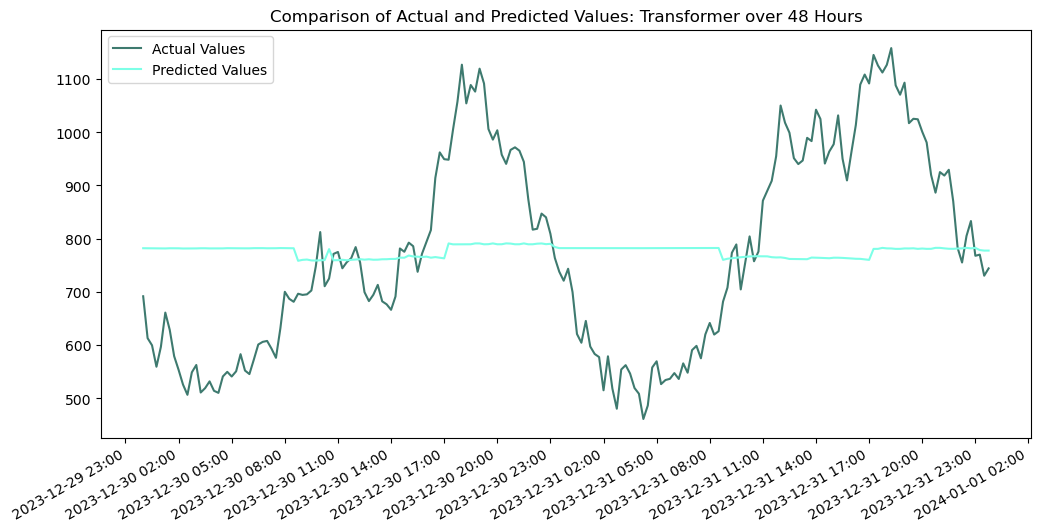

In [36]:
# Step 6 - Rescaling, error metrics and visualization

# Load the best model weights
best_model_path = 'best_model.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

# Evaluate the model
model.eval()
test_predictions = []
with torch.no_grad():  # No gradients needed for inference
    for i in range(len(X_test_tensors)):
        X_batch = X_test_tensors[i].unsqueeze(0)  # Add batch dimension
        y_pred = model(X_batch)  # No hidden state needed for Transformer
        test_predictions.append(y_pred.squeeze().item())  # Remove batch dimension and convert to item

# Denormalization of predictions and actual values
test_predictions_denorm = lastgang_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_denorm = lastgang_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculation of error metrics
mse = mean_squared_error(y_test_denorm, test_predictions_denorm)  # Mean Squared Error
mae = mean_absolute_error(y_test_denorm, test_predictions_denorm)  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Square Error
mape = np.mean(np.abs((y_test_denorm - test_predictions_denorm) / y_test_denorm)) * 100  # Mean Absolute Percentage Error

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Visualization of actual vs predicted values
plt.figure(figsize=(12, 6))
test_dates = pd.date_range(start=dfEnergyAll.index[-len(X_test):][0], periods=len(y_test), freq='15T')
plt.plot(test_dates, y_test_denorm, label='Actual Values', color='#3E7A6F')
plt.plot(test_dates, test_predictions_denorm, label='Predicted Values', color='#7DFFE7')
plt.legend()
plt.title('Comparison of Actual and Predicted Values: Transformer over 48 Hours')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format x-axis for dates
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Set major tick intervals
plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability
plt.show()

In [37]:
# Step 6 - Rescaling, error metrics and visualization

# Saving the model for later
torch.save(model.state_dict(), 'transformer_model.pth')

In [38]:
# Step 7 - Show GPU Utilization and Memory Usage after Model Training

print("GPU after model training:", datetime.now().strftime("%Y-%m-%d %H:%M:%S")) # Print GPU utilization after model training
print_gpu_utilization() # Call function to print GPU utilization

print("CPU after model training:") # Print CPU utilization after model training
print_cpu_utilization() # Call function to print CPU utilization

print("RAM after model training:") # Print RAM usage after model training
print_memory_usage() # Call function to print RAM usage

GPU after model training: 2024-05-03 17:30:49
GPU: NVIDIA A100 80GB PCIe, GPU RAM Free: 14824.0MB, Used: 66214.0MB, Utilization: 24.0%
GPU: NVIDIA A100 80GB PCIe, GPU RAM Free: 236.0MB, Used: 80803.0MB, Utilization: 55.00000000000001%
CPU after model training:
CPU Utilization: 81.2%
RAM after model training:
Total memory: 146.88 GB
Available memory: 110.39 GB
Used memory: 34.70 GB
Memory usage: 24.8%


## 2 - Transformer-Architecture with Energy consumption data and 2 variables 'Lastgang_Moving_Average' and 'Lastgang_First_Difference'

In [ ]:
# Step 3 - Data Scaling

# Initialize the scalers
lastgang_scaler = MinMaxScaler(feature_range=(0, 1))  # Scaler for the target variable
features_scaler = MinMaxScaler(feature_range=(0, 1))  # Scaler for the feature variables

# Apply the scaler to the appropriate columns
dfEnergyAll['Lastgang'] = lastgang_scaler.fit_transform(dfEnergyAll['Lastgang'].values.reshape(-1, 1))  # Scale the main target variable
dfEnergyAll[['Lastgang_Moving_Average', 'Lastgang_First_Difference']] = features_scaler.fit_transform(dfEnergyAll[['Lastgang_Moving_Average', 'Lastgang_First_Difference']])  # Scale selected features


In [ ]:
# Step 4 - Creating the sequences, positional encoding and the LSTM model

# Step 2 - Data Preparation: Create sequences and add positional encoding
def create_sequences(data, seq_length):
    xs = []  # list to store sequences
    ys = []  # list to store target values corresponding to each sequence
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].to_numpy()  # extract sequence of length seq_length from data
        y = data.iloc[i + seq_length, 0]  # target value at the end of the sequence
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)  # convert lists to numpy arrays for machine learning processing

seq_length = 192  # define the length of sequences
X, y = create_sequences(dfEnergyAll, seq_length)  # create sequences and corresponding targets from the dataset

# Use the last 192 sequences for testing to maintain a comparable distribution as the TBATS model
X_train, X_test = X[:-192], X[-192:]  # split data into training and testing sets
y_train, y_test = y[:-192], y[-192:]  # split targets into training and testing sets

# Function for positional encoding
def positional_encoding(seq_len, d_model):
    encoding = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_model) for j in range(d_model)]
        if pos != 0 else np.zeros(d_model) 
        for pos in range(seq_len)
    ])
    encoding[1:, 0::2] = np.sin(encoding[1:, 0::2])  # apply sine to even indices
    encoding[1:, 1::2] = np.cos(encoding[1:, 1::2])  # apply cosine to odd indices
    return encoding

# Apply positional encodings
d_model = X_train.shape[2]  # number of features in the data
pos_enc = positional_encoding(seq_length, d_model)  # generate positional encoding based on sequence length and number of features

# Add positional encodings to the sequences
X_train_enc = np.array([x + pos_enc for x in X_train])  # add positional encoding to training data
X_test_enc = np.array([x + pos_enc for x in X_test])  # add positional encoding to testing data

In [ ]:
# Step 4 - Creating the sequences, positional encoding and the LSTM model

# Print the shapes of the training and testing datasets
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")

# Print the shapes of the training and testing datasets with positional encodings applied
print(f"X_train_enc Shape: {X_train_enc.shape}")
print(f"X_test_enc Shape: {X_test_enc.shape}")

In [ ]:
# Step 4 - Creating the sequences and the LSTM model

# Check Hardware Availability for the PyTorch code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Step 4 - Creating the sequences and the LSTM model

X_train_tensors = torch.Tensor(X_train_enc).to(device)  # Convert training data to tensors and move to the designated device (GPU or CPU)
y_train_tensors = torch.Tensor(y_train).view(-1, 1).to(device)  # Convert training labels to tensors, reshape them and move to the device
X_test_tensors = torch.Tensor(X_test_enc).to(device)  # Convert testing data to tensors and move to the designated device
y_test_tensors = torch.Tensor(y_test).view(-1, 1).to(device)  # Convert testing labels to tensors, reshape them and move to the device

In [ ]:
# Step 4 - Creating the sequences and the LSTM model

#Create Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers, nhead):
        super(TransformerModel, self).__init__()
        self.input_size = input_size  # Number of input features
        self.hidden_layer_size = hidden_layer_size  # Size of the hidden layer
        self.output_size = output_size  # Size of the output layer

        # Embedding layer that maps input features to the hidden layer size
        self.embedding = nn.Linear(input_size, hidden_layer_size)

        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_layer_size, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Linear layer for output
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, src):
        # Apply embedding to the source data
        src = self.embedding(src)

        # Transformer Encoder processes the data
        src = src.permute(1, 0, 2)  # Transformer expects [seq_len, batch, features]
        output = self.transformer_encoder(src)

        # Take only the output of the last time step for prediction
        output = output[-1]

        # Output through linear layer
        output = self.linear(output)
        return output

# Parameters
input_size = 3  # Number of input features
hidden_layer_size = 100  # Size of the hidden layer
output_size = 1  # Output size
num_layers = 2  # Number of layers in the transformer
nhead = 2  # Number of attention heads

# Instantiate the model
model = TransformerModel(input_size, hidden_layer_size, output_size, num_layers, nhead).to(device)  # Create the model and move it to the designated device

In [ ]:
# Step 5 - Model Training

# Define the number of epochs and batch size
loss_function = nn.MSELoss()  # Loss function for measuring the mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer with a learning rate of 0.001
epochs = 70  # Total number of epochs to train the model
batch_size = 12  # Number of samples per batch

# For storing the loss values
train_losses = []  # List to store training loss values for each epoch
test_losses = []  # List to store validation loss values for each epoch

# Initialize variables for Early Stopping
best_test_loss = float('inf')  # Best validation loss seen so far, initialized to infinity
best_model_path = 'best_model.pth'  # Path to save the best performing model
early_stopping_patience = 5  # Number of epochs to continue without improvement before stopping
epochs_without_improvement = 0  # Counter to track epochs without improvement

for epoch in range(epochs):  # Loop over each epoch
    model.train()  # Set the model to training mode
    train_loss = 0.0  # Reset training loss for this epoch
    for i in range(0, len(X_train_tensors), batch_size):  # Iterate over the training data in batches
        X_batch = X_train_tensors[i:i + batch_size]  # Get the current batch of input data
        y_batch = y_train_tensors[i:i + batch_size]  # Get the current batch of target data

        # Dynamic adjustment of the batch size for the last batch of the epoch
        actual_batch_size = X_batch.size(0)

        optimizer.zero_grad()  # Reset the gradients to zero

        # No need to manage hidden states for the Transformer model
        y_pred = model(X_batch)  # Forward pass through the model

        loss = loss_function(y_pred, y_batch)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights
        
        train_loss += loss.item() * actual_batch_size  # Accumulate the loss

    # Calculate the average training loss for this epoch
    train_loss /= len(X_train_tensors)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # No gradient calculations
        for i in range(0, len(X_test_tensors), batch_size):
            X_batch = X_test_tensors[i:i + batch_size]
            y_batch = y_test_tensors[i:i + batch_size]

            y_pred = model(X_batch)  # Forward pass through the model for validation
            loss = loss_function(y_pred, y_batch)  # Calculate loss
            test_loss += loss.item() * actual_batch_size  # Accumulate the loss
        
    # Calculate the average validation loss for this epoch
    test_loss /= len(X_test_tensors)
    test_losses.append(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss  # Update the best test loss
        torch.save(model.state_dict(), best_model_path)  # Save the best model
        epochs_without_improvement = 0  # Reset the improvement counter
        print(f'New best model saved at epoch {epoch+1} with test loss {test_loss}.')
    else:
        epochs_without_improvement += 1  # Increment the no-improvement counter

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early Stopping after {epoch+1} epochs!')  # Stop training if no improvement
        break

In [ ]:
# Step 5 - Model Training

#Printing the learning curve
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [ ]:
# Step 6 - Rescaling, error metrics and visualization

# Load the best model weights
best_model_path = 'best_model.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

# Evaluate the model
model.eval()
test_predictions = []
with torch.no_grad():  # No gradients needed for inference
    for i in range(len(X_test_tensors)):
        X_batch = X_test_tensors[i].unsqueeze(0)  # Add batch dimension
        y_pred = model(X_batch)  # No hidden state needed for Transformer
        test_predictions.append(y_pred.squeeze().item())  # Remove batch dimension and convert to item

# Denormalization of predictions and actual values
test_predictions_denorm = lastgang_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_denorm = lastgang_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculation of error metrics
mse = mean_squared_error(y_test_denorm, test_predictions_denorm)  # Mean Squared Error
mae = mean_absolute_error(y_test_denorm, test_predictions_denorm)  # Mean Absolute Error
rmse = np.sqrt(mse)  # Root Mean Square Error
mape = np.mean(np.abs((y_test_denorm - test_predictions_denorm) / y_test_denorm)) * 100  # Mean Absolute Percentage Error

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Visualization of actual vs predicted values
plt.figure(figsize=(12, 6))
test_dates = pd.date_range(start=dfEnergyAll.index[-len(X_test):][0], periods=len(y_test), freq='15T')
plt.plot(test_dates, y_test_denorm, label='Actual Values', color='#3E7A6F')
plt.plot(test_dates, test_predictions_denorm, label='Predicted Values', color='#7DFFE7')
plt.legend()
plt.title('Comparison of Actual and Predicted Values: Transformer over 48 Hours')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format x-axis for dates
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Set major tick intervals
plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability
plt.show()